## Imports

Here, we restrict the range of alpha/L1_lambda values for GridSearchCV (Lasso, Elastic Net, Ridge). We observed that when a broad range of hyperparameter values is used, applying the 1-standard-deviation rule afterwards tends to select highly regularized models. While these models may generalize better, they could also be slightly underfitted.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LassoLars
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error


# another way of ignoring warnings
import warnings
warnings.filterwarnings('ignore')

#### Loading dataset

In [2]:
Xtrain = pd.read_csv("Xytrain_regression.csv").iloc[:, 1:]
ytrain = pd.read_csv("Xytrain_regression.csv").iloc[:, 0]

Xtest = pd.read_csv("Xytest_regression.csv").iloc[:, 1:]
ytest = pd.read_csv("Xytest_regression.csv").iloc[:, 0]

In [3]:
Xall = pd.concat([Xtrain, Xtest], axis=0).reset_index(drop=True)
yall = pd.concat([ytrain, ytest], axis=0).reset_index(drop=True)

### Ridge Regression

Best parameters for Ridge:  {'alpha': 6.141414141414142}
Best cross-validation score: 0.7360
R² Score on the test dataset: 0.7768
MSE on the test dataset: 1148.6648
RMSE on the test dataset: 33.8920


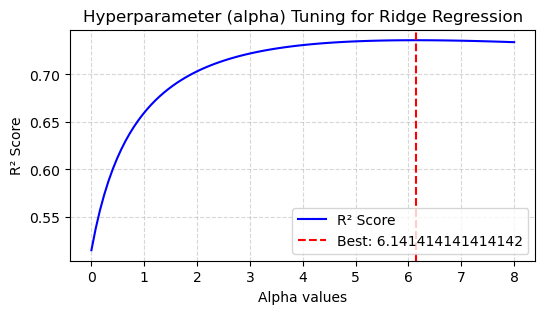

Best estimator: Ridge(alpha=6.141414141414142)


In [4]:
# Initialize Ridge regression model
ridge = Ridge()

# Define the hyperparameter grid for alpha
param_grid_ridge = {
    'alpha' : np.linspace(0, 8, 100)
}

# Define KFold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
#cv = LeaveOneOut()

# Use GridSearchCV with the KFold object
Ridge_ = GridSearchCV(ridge, param_grid_ridge, cv=cv, n_jobs=-1, return_train_score=True, scoring='r2')

# Fit the GridSearchCV
Ridge_.fit(Xtrain, ytrain)

# Print best parameters and best cross-validation score
print("Best parameters for Ridge: ", Ridge_.best_params_)
print("Best cross-validation score: {:.4f}".format(Ridge_.best_score_))

# Evaluate the best model on the test data
best_model_ridge = Ridge_.best_estimator_
y_pred_ridge = best_model_ridge.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_ridge)
test_MSE = mean_squared_error(ytest, y_pred_ridge)
test_RMSE = root_mean_squared_error(ytest, y_pred_ridge)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

# Get the mean test scores from the cross-validation results
alphas = np.linspace(0, 8, 100)
mean_test_scores = Ridge_.cv_results_['mean_test_score']

# Plot the results of hyperparameter tuning
plt.figure(figsize=(6, 3))
plt.plot(alphas, mean_test_scores, linestyle='-', color='b', label='R² Score')
plt.axvline(Ridge_.best_params_['alpha'], color='r', linestyle='--', label=f"Best: {Ridge_.best_params_['alpha']}")
plt.xlabel('Alpha values')
plt.ylabel('R² Score')
plt.title('Hyperparameter (alpha) Tuning for Ridge Regression')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best estimator
print(f'Best estimator: {Ridge_.best_estimator_}')

In [5]:
# Get the mean test R² scores and standard deviations
meanError = list(Ridge_.cv_results_['mean_test_score'])
stdError = Ridge_.cv_results_['std_test_score']

# Find the index of the model with the highest mean R² score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

# Select the model with the highest alpha (if there are multiple models that satisfy the condition)
if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
print(f'One standard error rule selects model with alpha: {Ridge_.cv_results_["param_alpha"][j]}')
print(f'One standard error rule gives the best model with mean_test_score (R²): {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 8.0
One standard error rule gives the best model with mean_test_score (R²): 0.7338981977228791 and std_test_score: 0.10190314152811483


In [6]:
alpha_ridge = Ridge_.cv_results_["param_alpha"][j]
ridge = Ridge(alpha=alpha_ridge)
ridge.fit(Xtrain, ytrain)
y_pred_ridge = ridge.predict(Xtest)

df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_ridge,
    'Squared Error (SE)': (ytest - y_pred_ridge) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_ridge)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

r2_ridge = r2_score(ytest, y_pred_ridge)
print(f'R² score for Ridge: {r2_ridge:.4f}')

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

R² score for Ridge: 0.7728
Mean Squared Error (MSE): 1169.76
Root Mean Squared Error (RMSE): 34.20
Standard Deviation of Actual Values: 73.61


### Lasso Regression

Best parameters for Lasso found:  {'alpha': 1.7575757575757578}
Best cross-validation score for Lasso: 0.8352
R² Score on the test dataset: 0.8370
MSE on the test dataset: 839.0849
RMSE on the test dataset: 28.9670


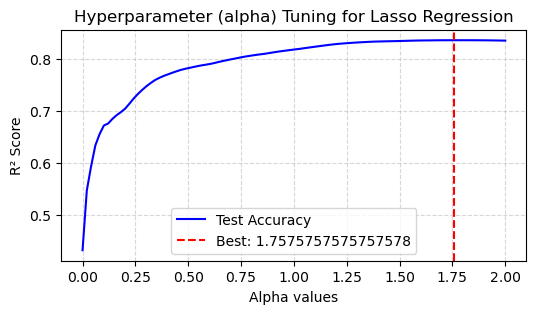

Best estimator: Lasso(alpha=1.7575757575757578)


In [7]:
# Initialize the Lasso model
lasso = Lasso()

# Define the hyperparameter grid for Lasso
param_grid_lasso = {
    'alpha': np.linspace(0, 2, 100)  # Fixed logspace range
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Set up the grid search with 5-fold cross-validation
Lasso_ = GridSearchCV(lasso, param_grid_lasso, cv=cv, scoring='r2')

# Fit the grid search to your training data
Lasso_.fit(Xtrain, ytrain)

# Print the best parameters and score
print("Best parameters for Lasso found: ", Lasso_.best_params_)
print("Best cross-validation score for Lasso: {:.4f}".format(Lasso_.best_score_))

# Access the best model
best_model_lasso = Lasso_.best_estimator_

# Make predictions on the test set
y_pred_lasso = best_model_lasso.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_lasso)
test_MSE = mean_squared_error(ytest, y_pred_lasso)
test_RMSE = root_mean_squared_error(ytest, y_pred_lasso)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

alphas = np.linspace(0, 2, 100) 
mean_test_scores = Lasso_.cv_results_['mean_test_score']

# Plot results
plt.figure(figsize=(6, 3))
plt.plot(alphas, mean_test_scores, linestyle='-', color='b', label='Test Accuracy')
plt.axvline(Lasso_.best_params_['alpha'], color='r', linestyle='--', label=f"Best: {Lasso_.best_params_['alpha']}")
plt.xlabel('Alpha values')
plt.ylabel('R² Score')
plt.title('Hyperparameter (alpha) Tuning for Lasso Regression')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best estimator
print(f'Best estimator: {Lasso_.best_estimator_}')

In [8]:
meanError = list(Lasso_.cv_results_['mean_test_score'])
stdError = Lasso_.cv_results_['std_test_score']

# Find the index of the model with the highest mean test score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
# We flip the sign of the std_error and compare
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
print(f'One standard error rule selects model with alpha: {Lasso_.cv_results_["param_alpha"][j]}')
print(f'One standard error rule gives the best model with mean_test_score: {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 2.0
One standard error rule gives the best model with mean_test_score: 0.8343988970447256 and std_test_score: 0.07770799351752641


In [9]:
alpha_lasso = Lasso_.cv_results_["param_alpha"][j]
lasso = Lasso(alpha=alpha_lasso)
lasso.fit(Xtrain, ytrain)
y_pred_lasso = lasso.predict(Xtest)
r2_lasso = r2_score(ytest, y_pred_lasso)
print(f'R² score for Lasso: {r2_lasso:.4f}')

df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_lasso,
    'Squared Error (SE)': (ytest - y_pred_lasso) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_lasso)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

R² score for Lasso: 0.8343
Mean Squared Error (MSE): 852.85
Root Mean Squared Error (RMSE): 29.20
Standard Deviation of Actual Values: 73.61


### ElasticNEt REgression

In [21]:
# Initialize the ElasticNet model
elasticNet = ElasticNet()

# Define the hyperparameter grid for ElasticNet
param_grid_en = {
    'alpha': np.linspace(0, 2, 100),  # Alpha on a log scale from 0 to 2
    'l1_ratio': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Set up the grid search with 10-fold cross-validation
EN_ = GridSearchCV(elasticNet, param_grid_en, cv=cv, scoring='r2')

# Fit the grid search to your training data
EN_.fit(Xtrain, ytrain)

# Print the best parameters and score
print("Best parameters for ElasticNet found: ", EN_.best_params_)
print("Best cross-validation score for ElasticNet: {:.4f}".format(EN_.best_score_))

# Access the best model
best_model_en = EN_.best_estimator_

# Make predictions on the test set
y_pred_en = best_model_en.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_en)
test_MSE = mean_squared_error(ytest, y_pred_en)
test_RMSE = np.sqrt(test_MSE)  # Fix RMSE calculation

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

# Print best estimator
print(f'Best estimator: {EN_.best_estimator_}')

# Extract the mean_test_score and reshape it to fit the grid of alphas and l1_ratios
mean_test_scores_grid = EN_.cv_results_['mean_test_score'].reshape(len(param_grid_en['l1_ratio']), len(param_grid_en['alpha']))

Best parameters for ElasticNet found:  {'alpha': 1.7575757575757578, 'l1_ratio': 1}
Best cross-validation score for ElasticNet: 0.8352
R² Score on the test dataset: 0.8370
MSE on the test dataset: 839.0849
RMSE on the test dataset: 28.9670
Best estimator: ElasticNet(alpha=1.7575757575757578, l1_ratio=1)


In [ ]:
# Retrieve the cross-validation results for ElasticNet
meanError = list(EN_.cv_results_['mean_test_score'])
stdError = EN_.cv_results_['std_test_score']

# Find the index of the model with the highest mean test score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
# We check if any models' mean test score is within one standard error of the best model's score
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler model with a higher alpha)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
selected_alpha = EN_.cv_results_['param_alpha'][j]
selected_l1_ratio = EN_.cv_results_['param_l1_ratio'][j]

print(f'One standard error rule selects model with alpha: {selected_alpha} and l1_ratio: {selected_l1_ratio}')
print(f'One standard error rule gives the best model with mean_test_score: {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 2.0 and l1_ratio: 1.0
One standard error rule gives the best model with mean_test_score: 0.8343988970447256 and std_test_score: 0.07770799351752641


In [ ]:
alpha_en = selected_alpha
l1_ratio_en = selected_l1_ratio

en = ElasticNet(alpha=alpha_en, l1_ratio=l1_ratio_en)
en.fit(Xtrain, ytrain)
y_pred_en = en.predict(Xtest)
r2_en = r2_score(ytest, y_pred_en)
print(f'R² score for ElasticNet: {r2_en:.4f}')

df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_en,
    'Squared Error (SE)': (ytest - y_pred_en) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_en)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

R² score for ElasticNet: 0.8343
Mean Squared Error (MSE): 852.85
Root Mean Squared Error (RMSE): 29.20
Standard Deviation of Actual Values: 73.61


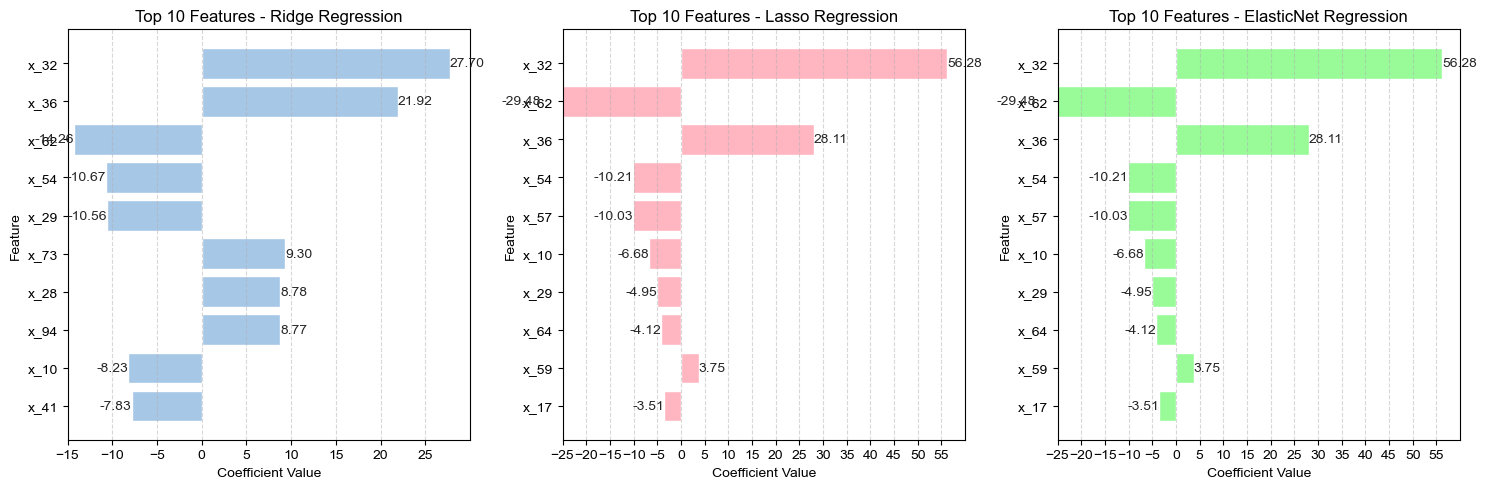

In [ ]:
# Feature names (assuming Xtrain is a DataFrame, otherwise use indices)
feature_names = Xtrain.columns

def get_top_features(model):
    """Extract top 10 features based on absolute weight values."""
    coef = model.coef_
    abs_coef = np.abs(coef)
    
    # Get indices of top 10 features
    top_indices = np.argsort(abs_coef)[-10:]  # Top 10 by absolute magnitude
    
    # Get feature names and corresponding values
    top_features = [feature_names[i] for i in top_indices]
    top_values = coef[top_indices]
    
    return top_features, top_values

# Get top features for each model
ridge_features, ridge_values = get_top_features(ridge)
lasso_features, lasso_values = get_top_features(lasso)
en_features, en_values = get_top_features(en)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Use Seaborn style for pastel aesthetics
sns.set_style("whitegrid")

# Define pastel colors
colors = ["#A7C7E7", "#FFB6C1", "#98FB98"]  # Pastel Blue, Pastel Pink, Pastel Green

# Function to plot bars with values on top
def plot_feature_importance(ax, features, values, title, color, xlim_range):
    ax.barh(features, values, color=color)
    ax.set_title(title)
    ax.set_xlabel("Coefficient Value")
    ax.set_ylabel("Feature")
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.set_xlim(xlim_range[0], xlim_range[1])
    ax.set_xticks(np.arange(xlim_range[0], xlim_range[1], 5))

    # Add value labels
    for i, v in enumerate(values):
        ax.text(v, i, f"{v:.2f}", va='center', ha="left" if v > 0 else "right", fontsize=10)

# Plot Ridge
plot_feature_importance(axes[0], ridge_features, ridge_values, "Top 10 Features - Ridge Regression", colors[0], (-15, 30))

# Plot Lasso
plot_feature_importance(axes[1], lasso_features, lasso_values, "Top 10 Features - Lasso Regression", colors[1], (-25, 60))

# Plot ElasticNet
plot_feature_importance(axes[2], en_features, en_values, "Top 10 Features - ElasticNet Regression", colors[2], (-25, 60))

# Adjust layout
plt.tight_layout()
plt.show()

#### Least angle regression and selection (LARS)

The Least Angle Regression (LARS) method The Lasso strategy in linear regression combines the regularization capabilities of L1 regularization (also called Lasso) with the efficiency of forward selection. Loss of arousal As it moves in the direction of the target variable's greatest correlation, Lasso gradually adds features to the model. This process is continued until a point is reached at which the correlation between the additional variable and the original one would be equal. Due to its tendency to choose a sparse subset of characteristics, this approach works especially well with high-dimensional data. Models with fewer non-zero coefficients are encouraged to be sparse by the regularization term (L1 penalty).

Positive LAsso: Better Stability: Helps avoid issues when highly correlated features lead to coefficients flipping signs.

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best n_nonzero_coefs: 1.7575757575757578
Best Cross-Validation R² score: 0.8352
R² Score on the test dataset: 0.8369
MSE on the test dataset: 839.5121
RMSE on the test dataset: 28.9743


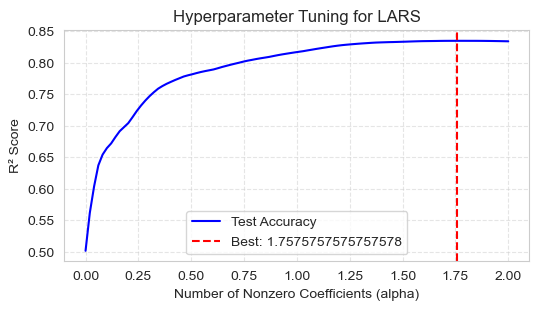

Best estimator: LassoLars(alpha=1.7575757575757578)


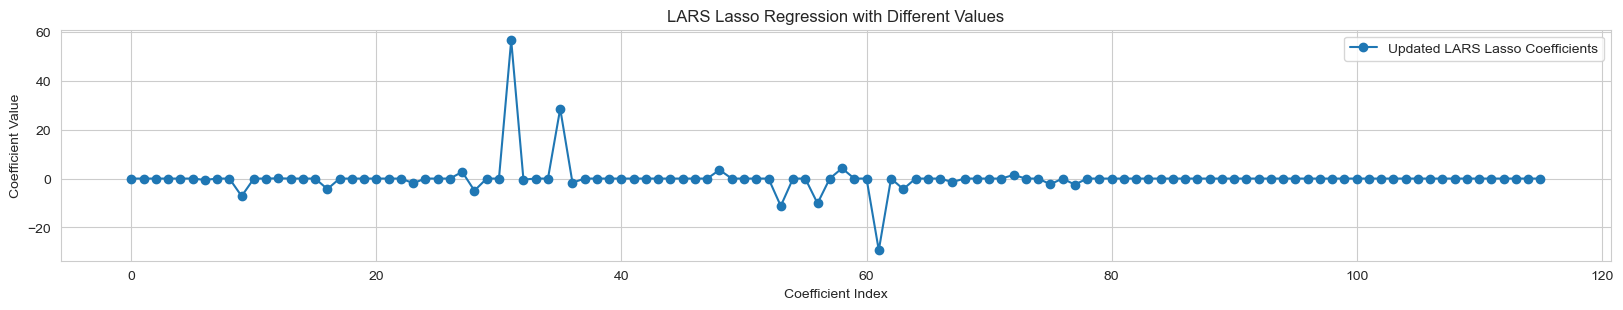

In [ ]:
# Define cross-validation strategy
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define hyperparameter grid
param_grid = {
    "alpha": np.linspace(0, 2, 100)
} 

# Define Lars model
lassolars = LassoLars()

# Use GridSearchCV
LAssoLars_ = GridSearchCV(lassolars, param_grid, scoring="r2", cv=kf, n_jobs=-1, verbose=1)
LAssoLars_.fit(Xtrain, ytrain)

# Get best parameters & results
best_n = LAssoLars_.best_params_["alpha"]
best_mse = LAssoLars_.best_score_

print(f"Best n_nonzero_coefs: {best_n}")
print(f"Best Cross-Validation R² score: {best_mse:.4f}")

# Access the best model
best_model_lars = LAssoLars_.best_estimator_

# Make predictions on the test set
y_pred_lars = best_model_lars.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_lars)
test_MSE = mean_squared_error(ytest, y_pred_lars)
test_RMSE = root_mean_squared_error(ytest, y_pred_lars)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

alphas = np.linspace(0, 2, 100)
mean_test_scores = LAssoLars_.cv_results_['mean_test_score']

# Plot results
plt.figure(figsize=(6, 3))
plt.plot(alphas, mean_test_scores, linestyle='-', color='b', label='Test Accuracy')
plt.axvline(LAssoLars_.best_params_['alpha'], color='r', linestyle='--', label=f"Best: {LAssoLars_.best_params_['alpha']}")
plt.xlabel('Alpha values')
plt.ylabel('R² Score')
plt.title('Hyperparameter (alpha) Tuning for LassoLars')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best estimator
print(f'Best estimator: {LAssoLars_.best_estimator_}')

plt.figure(figsize=(20, 3))
plt.plot(best_model_lars.coef_, marker='o', label='Updated LARS Lasso Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.title('LARS Lasso Regression with Different Values')
plt.show()

In [ ]:
# Retrieve cross-validation results for LARS
meanError = list(LAssoLars_.cv_results_['mean_test_score'])  # Mean R² scores
stdError = LAssoLars_.cv_results_['std_test_score']  # Standard deviation of R² scores

# Find the index of the best-performing model (highest mean test score)
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

# Select the most regularized model within the one standard error range
if len(J) > 0:
    j = int(J[-1])  # Choose the most regularized model (simpler with fewer nonzero coefficients)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one
    
# Print results
print(f'One Standard Error Rule selects model with alpha: {LAssoLars_.cv_results_["param_alpha"][j]}')
print(f'Mean R² Score: {meanError[j]:.4f}, Std Error: {stdError[j]:.4f}')

One Standard Error Rule selects model with alpha: 2.0
Mean R² Score: 0.8344, Std Error: 0.0777


In [ ]:
alpha_lassolars = LAssoLars_.cv_results_["param_alpha"][j]
lassolars = LassoLars(alpha = alpha_lassolars)
lassolars.fit(Xtrain, ytrain)
y_pred_lassolars = lassolars.predict(Xtest)
r2_lassolars = r2_score(ytest, y_pred_lassolars)
print(f'R² score for ElasticNet: {r2_en:.4f}')

df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_lassolars,
    'Squared Error (SE)': (ytest - y_pred_lassolars) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_lassolars)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

R² score for ElasticNet: 0.8343
Mean Squared Error (MSE): 853.28
Root Mean Squared Error (RMSE): 29.21
Standard Deviation of Actual Values: 73.61


In [ ]:
# Get non-zero coefficients and corresponding feature indices
non_zero_indices = lassolars.coef_ != 0
non_zero_features = Xtrain.columns[non_zero_indices]  # Feature names (if using Pandas)
non_zero_coefs = lassolars.coef_[non_zero_indices]  # Corresponding coefficients

# Sort features by absolute coefficient value in descending order
sorted_indices = abs(non_zero_coefs).argsort()[::-1]
sorted_features = non_zero_features[sorted_indices]
sorted_coefs = non_zero_coefs[sorted_indices]

# Print sorted results
print("Selected Features and Coefficients (sorted by importance):")
for feature, coef in zip(sorted_features, sorted_coefs):
    print(f"{feature}: {coef:.4f}")

Selected Features and Coefficients (sorted by importance):
x_32: 56.2837
x_62: -29.4828
x_36: 28.0918
x_54: -10.2140
x_57: -10.0435
x_10: -6.6760
x_29: -4.9632
x_64: -4.1276
x_59: 3.7450
x_17: -3.5075
x_49: 2.8522
x_78: -2.5674
x_76: -2.3083
x_24: -1.9533
x_28: 1.7634
x_37: -1.3472
x_73: 1.0997
x_68: -0.9135
x_07: -0.1795


In [ ]:
df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_lassolars,
    'Squared Error (SE)': (ytest - y_pred_lassolars) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_lassolars)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}\n")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

print(df_compare)

Mean Squared Error (MSE): 853.28
Root Mean Squared Error (RMSE): 29.21
Standard Deviation of Actual Values: 73.61

        Actual  Predicted  Squared Error (SE)  Absolute Error (AE)
0    74.689125  66.435698           68.119056             8.253427
1   110.649150  71.011813         1571.118448            39.637337
2    54.062438  72.762346          349.686549            18.699908
3    -5.811144  28.149383         1153.317332            33.960526
4  -127.836283 -91.028292         1354.828174            36.807991
5   -34.997160 -48.780384          189.977281            13.783225
6     5.436023 -13.527546          359.616951            18.963569
7   -80.081820 -68.481531          134.566697            11.600289
8   -12.344749 -30.154203          317.176657            17.809454
9    63.214673  51.894420          128.148131            11.320253
10  -55.422649   4.709079         3615.824738            60.131728
11  -54.444574 -46.175271           68.381368             8.269303
12  101.773460

In [ ]:
# Ridge
ridgeFinal = Ridge(alpha=alpha_ridge)
ridgeFinal.fit(Xall, yall)
joblib.dump(ridgeFinal, "RidgeTrained_model.pkl")

# Lasso
LAssoFinal = Lasso(alpha=alpha_lasso)
LAssoFinal.fit(Xall, yall)
joblib.dump(LAssoFinal, "LAssoTrained_model.pkl")

# EN
ENFinal = ElasticNet(alpha=alpha_en, l1_ratio=l1_ratio_en)
ENFinal.fit(Xall, yall)
joblib.dump(ENFinal, "ENTrained_model.pkl")

# LarsLasso
LarsLassoFinal = Lasso(alpha=alpha_lassolars)
LarsLassoFinal.fit(Xall, yall)
joblib.dump(LarsLassoFinal, "LarsLassoTrained_model.pkl")

['LarsLassoTrained_model.pkl']